## 13. Tagging Task
* Tagging task: 자연어처리 분야에서 각 단어가 어떤 유형에 속해있는지를 알아냄
* 크게 2가지
1. 개체명 인식(Named Entity Recognition): 각 단어의 유형이 사람, 장소, 단체 등 어떤 유형인지를 알아냄
2. 품사 태깅(Part of Speech Tagging): 각 단어의 품사가 명사, 동사, 형용사인지를 알아냄
* Keras를 이용해서 인공 신경망을 이용한 개체명 인식기와 품사 태거를 만드는 미니 프로젝트 수행

### 1) 케라스를 이용한 태깅 작업 개요(Tagging Task using Keras)
* 이번 챕터에서는 케라스(Keras)로 인공 신경망을 이용하여 태깅 작업을 하는 모델을 만듦
* 개체명 인식기와 품사 태거. 두 작업의 공통점은 **RNN의 다-대-다(Many-to-Many)** 작업이면서 또한 앞, 뒤 시점의 입력을 모두 참고하는 **양방향 RNN(Bidirectional RNN)**을 사용한다는 점

#### 1. 훈련 데이터에 대한 이해
* 텍스트 분류 작업과 동일하게 지도 학습(Supervised learning)에 속함
* 태깅을 해야 하는 단어 데이터 X, 레이블에 해당되는 태깅 정보 데이터는 y 


* X와 y 데이터의 쌍(pair)는 병렬 구조를 가진다는 특성. X와 y의 각 데이터의 길이는 같음
* 각 데이터는 정수 인코딩 과정을 거친 후, 모든 데이터의 길이를 동일하게 맞춰주기 위한 패딩(Padding) 작업을 거침

#### 2. 시퀀스 레이블링(Sequence Labeling)
* 입력 시퀀스에 대하여 레이블 시퀀스를 각각 부여하는 작업을 Sequence Labeling Task라고 함

#### 3. 양방향 LSTM(Bidirectional LSTM)
> model.add(Bidirectional(LSTM(hidden_size, return_sequences=True)))

* 이전 시점의 단어 정보 뿐만 아니라 다음 시점의 단어 정보도 참고하기 위하여 bidirectional LSTM
* 인자 정보: 인자값을 하나 줄 경우에는 이는 hidden_size, 결과적으로 output_dim이 됨

#### 4. RNN의 다-대-다(Many-to-Many) 문제
* RNN의 은닉층은 모든 시점에 대해서 은닉 상태값을 출력할 수 있고, 마지막 시점에 대해서만 은닉 상태값을 출력할 수 있음
  * 이는 인자로 **return_sequences=True**를 넣을 것인지, 넣지 않을 것인지로 설정
  * 태깅 작업은 Many-to-Many로 True로 설정


## 2). 양방향 LSTM을 이용한 품사 태깅(Part-of-speech Tagging using Bi-LSTM)
* 2챕터 토큰화 챕터에서는 NLTK와 KoNLPy를 이용해서 이미 기존에 있는 모델로 품사 태깅을 수행했지만, 여기에서는 직접 양방향 LSTM을 이용한 품사 태깅을 수행하는 모델
### 1. 품사 태깅 데이터에 대한 이해와 전처리

In [3]:
!pip install nltk

In [4]:
import nltk
nltk.download('treebank')

[nltk_data] Downloading package treebank to /root/nltk_data...
[nltk_data]   Unzipping corpora/treebank.zip.


True

In [5]:
# 양방향 LSTM을 이용해서 품사 태깅을 하는 모델

import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split

* NLTK를 이용하면 영어 코퍼스에서 투큰화와 품사 태깅 전처리를 진행한 문장 데이터를 받아올 수 있음
* 여기서는 해당 데이터를 훈련시켜 품사 태깅을 수행하는 모델을 만듦

In [6]:
# 전체 문장 샘플의 개수 확인
tagged_sentences = nltk.corpus.treebank.tagged_sents() # 토큰화에 품사 태깅이 된 데이터 받아오기
print("품사 태깅이 된 문장 개수: ", len(tagged_sentences)) # 문장 샘플의 개수 출력

품사 태깅이 된 문장 개수:  3914


In [7]:
# 첫번째 샘플만 출력
print(tagged_sentences[0])

[('Pierre', 'NNP'), ('Vinken', 'NNP'), (',', ','), ('61', 'CD'), ('years', 'NNS'), ('old', 'JJ'), (',', ','), ('will', 'MD'), ('join', 'VB'), ('the', 'DT'), ('board', 'NN'), ('as', 'IN'), ('a', 'DT'), ('nonexecutive', 'JJ'), ('director', 'NN'), ('Nov.', 'NNP'), ('29', 'CD'), ('.', '.')]


* 훈련을 시키려면 훈련 데이터에서 단어에 해당되는 부분과 품사 태깅 정보에 해당되는 부분은 분리시켜야 함. 
  * 즉, Pierre, Vinken 같이, NNP와 NNP 같이
  * 이런 경우, **zip()** 함수가 유용한 역할. **zip() 함수는 동일한 개수를 가지는 시퀀스 자료형에서 각 순서에 등장하는 원소끼리 묶어주는 역할**

In [8]:
sentences, pos_tags = [], []
for tagged_sentence in tagged_sentences: #3914개의 문장 샘플을 1개씩 불러옴
  sentence, tag_info = zip(*tagged_sentence) # 각 샘플에서 단어들은 sentence에 품사 태깅 정보들은 tag_info에 저장
  sentences.append(list(sentence)) #각 샘플에서 단어 정보만 저장
  pos_tags.append(list(tag_info)) #각 샘플에서 품사 태깅 정보만 저장

  #sentences.append(list(sentence))에서 list 없으면 ()로 묶임

In [9]:
print(sentences[0])
print(pos_tags[0])

['Pierre', 'Vinken', ',', '61', 'years', 'old', ',', 'will', 'join', 'the', 'board', 'as', 'a', 'nonexecutive', 'director', 'Nov.', '29', '.']
['NNP', 'NNP', ',', 'CD', 'NNS', 'JJ', ',', 'MD', 'VB', 'DT', 'NN', 'IN', 'DT', 'JJ', 'NN', 'NNP', 'CD', '.']


샘플의 최대 길이 : 271
샘플의 평균 길이 : 25.722024


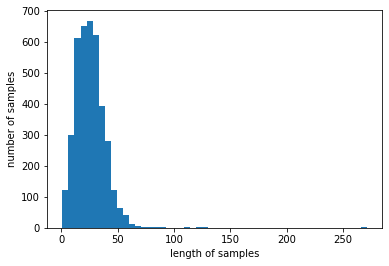

In [10]:
# 전체 데이터의 길이 분포
print('샘플의 최대 길이 : %d' % max(len(l) for l in sentences))
print('샘플의 평균 길이 : %f' % (sum(map(len, sentences))/len(sentences)))
plt.hist([len(s) for s in sentences], bins=50)
plt.xlabel('length of samples')
plt.ylabel('number of samples')
plt.show()

In [11]:
# 케라스 토크나이저를 다음과 같이 함수로 구현
def tokenize(samples):
  tokenizer = Tokenizer()
  tokenizer.fit_on_texts(samples)
  return tokenizer

In [12]:
# 문장 데이터에 대해서는 src_tokenizer, 레이블에 해당되는 품사 태깅 정보에 대해서는 tar_tokenizer 사용
src_tokenizer = tokenize(sentences)
tar_tokenizer = tokenize(pos_tags)

In [13]:
# 단어 집합과 품사 태깅 정보 집합의 크기 확인
vocab_size = len(src_tokenizer.word_index) + 1
tag_size = len(tar_tokenizer.word_index) + 1
print('단어 집합의 크기 : {}'.format(vocab_size))
print('태깅 정보 집합의 크기 : {}'.format(tag_size))

단어 집합의 크기 : 11388
태깅 정보 집합의 크기 : 47


In [14]:
# 정수 인코딩
X_train = src_tokenizer.texts_to_sequences(sentences)
y_train = tar_tokenizer.texts_to_sequences(pos_tags)

In [15]:
print(X_train[:2])
print(y_train[:2])

[[5601, 3746, 1, 2024, 86, 331, 1, 46, 2405, 2, 131, 27, 6, 2025, 332, 459, 2026, 3], [31, 3746, 20, 177, 4, 5602, 2915, 1, 2, 2916, 637, 147, 3]]
[[3, 3, 8, 10, 6, 7, 8, 21, 13, 4, 1, 2, 4, 7, 1, 3, 10, 9], [3, 3, 17, 1, 2, 3, 3, 8, 4, 3, 19, 1, 9]]


In [16]:
# 샘플의 모든 길이를 임의로 150으로 맞춤
# 케라스의 pad_sequences()
max_len = 150
X_train = pad_sequences(X_train, padding='post', maxlen=max_len)
y_train = pad_sequences(y_train, padding='post', maxlen=max_len)

In [17]:
# 모든 샘플의 길이가 150
# 이제 훈련 데이터 비율로 분리
X_train, X_test, y_train, y_test = train_test_split(X_train, y_train, test_size=0.2, random_state=777)

In [18]:
# 레이블에 해당되는 태깅 정보에 대해서 원-핫 인코딩 수행
y_train = to_categorical(y_train, num_classes=tag_size)
y_test = to_categorical(y_test, num_classes=tag_size)

In [19]:
# 각 데이터에 대한 크기 확인
print('훈련 샘플 문장의 크기 : {}'.format(X_train.shape))
print('훈련 샘플 레이블의 크기 : {}'.format(y_train.shape))
print('테스트 샘플 문장의 크기 : {}'.format(X_test.shape))
print('테스트 샘플 레이블의 크기 : {}'.format(y_test.shape))

훈련 샘플 문장의 크기 : (3131, 150)
훈련 샘플 레이블의 크기 : (3131, 150, 47)
테스트 샘플 문장의 크기 : (783, 150)
테스트 샘플 레이블의 크기 : (783, 150, 47)


### 2. 양방향 LSTM(Bi-directional LSTM)으로 POS Tagger 만들기

In [20]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, InputLayer, Bidirectional, TimeDistributed, Embedding
from tensorflow.keras.optimizers import Adam

In [21]:
embedding_dim = 128
hidden_units = 128

model = Sequential()
model.add(Embedding(vocab_size, embedding_dim, mask_zero=True))
model.add(Bidirectional(LSTM(hidden_units, return_sequences=True)))
model.add(TimeDistributed(Dense(tag_size, activation=('softmax'))))
model.compile(loss='categorical_crossentropy', optimizer=Adam(0.001), metrics=['accuracy'])

TimeDistributed는 many 출력을 가진 모델에 사용
* 각 시간별로 출력되는 모든 출력값에 대해서 cost를 구해서 gradient를 구함

* one 출력 모델은 최종 출력 하나에서 gradient를 계산해 앞으로 보내고,
many의 경우는 중간 출력 결과에 대해서도 gradient 계산

In [22]:
model.fit(X_train, y_train, batch_size=128, epochs=6, validation_data=(X_test, y_test))

Epoch 1/6
25/25 [==============================] - 46s 2s/step - loss: 0.5942 - accuracy: 0.1348 - val_loss: 0.5160 - val_accuracy: 0.1870
Epoch 2/6
25/25 [==============================] - 36s 1s/step - loss: 0.5036 - accuracy: 0.1915 - val_loss: 0.4810 - val_accuracy: 0.2184
Epoch 3/6
25/25 [==============================] - 36s 1s/step - loss: 0.4524 - accuracy: 0.3604 - val_loss: 0.4014 - val_accuracy: 0.4558
Epoch 4/6
25/25 [==============================] - 37s 1s/step - loss: 0.3407 - accuracy: 0.5173 - val_loss: 0.2744 - val_accuracy: 0.6004
Epoch 5/6
25/25 [==============================] - 36s 1s/step - loss: 0.2207 - accuracy: 0.6991 - val_loss: 0.1719 - val_accuracy: 0.7793
Epoch 6/6
25/25 [==============================] - 36s 1s/step - loss: 0.1277 - accuracy: 0.8526 - val_loss: 0.1044 - val_accuracy: 0.8709


In [23]:
print("\n 테스트 정확도: %.4f" % (model.evaluate(X_test, y_test)[1]))

25/25 [==============================] - 3s 106ms/step - loss: 0.1044 - accuracy: 0.8709

 테스트 정확도: 0.8709


* 실제 맞추고 있는지를 특정 테스트 데이터를 주고 직접 출력해서 확인
* 인덱스로부터 단어와 품사 태깅 정보를 리턴하는 index_to_word와 index_to_tag를 만들고 이를 이용하여 실제값과 예측값을 출력

In [24]:
index_to_word = src_tokenizer.index_word
index_to_tag = tar_tokenizer.index_word

i = 10 # 확인하고 싶은 테스트용 샘플 인덱스
y_predicted = model.predict(np.array([X_test[i]])) #입력한 테스트용 샘플에 대해서 예측 y를 리턴
y_predicted = np.argmax(y_predicted, axis=-1) # 원-핫 인코딩을 다시 정수 인코딩으로 변경함
true = np.argmax(y_test[i], -1) # 원핫 인코딩을 다시 정수 인코딩으로 변경

print("{:15}|{:5}|{}".format("단어", "실제값", "예측값"))
print(35 * "-")

for w, t, pred in zip(X_test[i], true, y_predicted[0]):
    if w != 0: # PAD값은 제외함.
        print("{:17}: {:7} {}".format(index_to_word[w], index_to_tag[t].upper(), index_to_tag[pred].upper()))

단어             |실제값  |예측값
-----------------------------------
in               : IN      IN
addition         : NN      NN
,                : ,       ,
buick            : NNP     NNP
is               : VBZ     VBZ
a                : DT      DT
relatively       : RB      JJ
respected        : VBN     VBN
nameplate        : NN      NN
among            : IN      IN
american         : NNP     NNP
express          : NNP     NNP
card             : NN      NN
holders          : NNS     NNS
,                : ,       ,
says             : VBZ     VBZ
0                : -NONE-  -NONE-
*t*-1            : -NONE-  -NONE-
an               : DT      DT
american         : NNP     NNP
express          : NNP     NNP
spokeswoman      : NN      NN
.                : .       .


### 3. 양방향 LSTM + CRF(Bidirectional LSTM + CRF)로 POS Tagger 만들기
* 양방향 LSTM에 추가적으로 사용하면 성능을 높일 수 있다고 알려진 CRF layer를 추가하여 실습 진행
* tf2crf라는 패키지 설치

In [25]:
!pip install tf2crf

     |████████████████████████████████| 1.1 MB 5.9 MB/s 


In [26]:
# 이전 모델에 CRF layer를 추가한 새로운 모델 만들기
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Embedding, Bidirectional, LSTM, TimeDistributed, Dense, Input
from tf2crf import CRF, ModelWithCRFLoss

In [27]:
inputs = Input(shape=(None, ), dtype='int32')
output = Embedding(vocab_size, 128, mask_zero=True)(inputs)
output = Bidirectional(LSTM(128, return_sequences=True))(output)
crf = CRF(tag_size) ##
output = crf(output) ##
base_model = Model(inputs, output)

model = ModelWithCRFLoss(base_model, sparse_target = False) ##
model.build(input_shape=(None, 22))
model.compile(optimizer='adam')

/usr/local/lib/python3.7/dist-packages/tensorflow/python/autograph/impl/api.py:376: UserWarning: CRF decoding models have serialization issues in TF >=2.5 . Please see isse #2476
  return py_builtins.overload_of(f)(*args)


In [28]:
history = model.fit(X_train, y_train, batch_size = 32, epochs = 5, validation_split = 0.2, verbose = 1)

'''
함수 인자로 verbose가 있으면 함수 수행시 발생하는 상세한 정보들을 표준 출력으로 자세히 내보낼 것인가를 나타냅니다. 
보통 0 은 출력하지 않고, 1은 자세히, 2는 함축적인 정보만 출력하는 형태
'''

Epoch 1/5


/usr/local/lib/python3.7/dist-packages/tensorflow/python/autograph/impl/api.py:376: UserWarning: CRF decoding models have serialization issues in TF >=2.5 . Please see isse #2476
  return py_builtins.overload_of(f)(*args)


79/79 [==============================] - 71s 763ms/step - loss: 76.7682 - accuracy: 0.2125 - val_loss_val: 57.4945 - val_val_accuracy: 0.4231
Epoch 2/5
79/79 [==============================] - 57s 726ms/step - loss: 37.5177 - accuracy: 0.6161 - val_loss_val: 21.0109 - val_val_accuracy: 0.8043
Epoch 3/5
79/79 [==============================] - 57s 728ms/step - loss: 12.3420 - accuracy: 0.8963 - val_loss_val: 9.6588 - val_val_accuracy: 0.9020
Epoch 4/5
79/79 [==============================] - 58s 730ms/step - loss: 5.1287 - accuracy: 0.9570 - val_loss_val: 7.1016 - val_val_accuracy: 0.9222
Epoch 5/5
79/79 [==============================] - 57s 726ms/step - loss: 2.9149 - accuracy: 0.9740 - val_loss_val: 6.3677 - val_val_accuracy: 0.9240


In [ ]:
print("\n 테스트 정확도: %.4f" % (model.evaluate(X_test, y_test)[1]))

## 3) 개체명 인식 Named Entity Recognition
* 코퍼스로부터 각 개체 entity의 유형을 인식하는 개체명 인식
* 개체명 인식을 사용하면 코퍼스로부터 어떤 단어가 사람, 장소, 조직 등을 의미하는 단어인지 찾을 수 있음

### 1. 개체명 인식 Named Entity Recognition이란?
* 개체명 인식이란, 말 그대로 이름을 가진 개체 named entity를 인식하겠다는 것을 의미
* 좀 더 쉽게 설명하면, 어떤 이름을 의미하는 단어를 보고는 그 단어가 어떤 유형인지 인식하는 것
* ex) 유정이는 2018년에 골드만삭스에 입사했다. 
  > person, organization, time에 대해서 개체명 인식을 수행하는 모델이라면 다음과 같은 결과를 보여줌. 유정 - 사람, 2018년 - 시간, 골드만삭스 - 조직


* 개체명 인식 모델이 개체명을 인식하기 위해서는 보통 **전처리 과정**이 필요. 개체명 모델에 따라서는 품사 정보(POS Tagging, Part-Of-Speech Tagging)를 입력으로 요구하기도 함

## 2. NLTK를 이용한 개체명 인식(Named Entity Recognition using NLTK)
* NLTK에서는 개체명 인식기 (NER Chunker)를 지원하고 있으므로, 별도 개체명 인식기를 구현할 필요 없이 NLTK를 사용해서 개체명 인식을 수행 가능

In [37]:
nltk.download('maxent_ne_chunker')
nltk.download('words')
nltk.download('punkt')
nltk.download('averaged_perceptron_tagger')

[nltk_data] Downloading package maxent_ne_chunker to
[nltk_data]     /root/nltk_data...
[nltk_data]   Package maxent_ne_chunker is already up-to-date!
[nltk_data] Downloading package words to /root/nltk_data...
[nltk_data]   Package words is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger.zip.


True

In [38]:
from nltk import word_tokenize, pos_tag, ne_chunk
sentence = "James is working at Disney in London"
sentence = pos_tag(word_tokenize(sentence))
print(sentence) #토큰화와 품사 태깅을 동시 수행

[('James', 'NNP'), ('is', 'VBZ'), ('working', 'VBG'), ('at', 'IN'), ('Disney', 'NNP'), ('in', 'IN'), ('London', 'NNP')]


In [39]:
# 개체명 인식
sentence = ne_chunk(sentence)
print(sentence)

(S
  (PERSON James/NNP)
  is/VBZ
  working/VBG
  at/IN
  (ORGANIZATION Disney/NNP)
  in/IN
  (GPE London/NNP))


* **ne_chunk는 개체명을 태깅하기 위해서 앞서 품사 태깅(pos_tag)이 수행되어야 함**
* James는 PERSON, Disney는 ORGANIZATION, London은 위치GPE라고 정상적으로 개체명 인식이 수행된 것

## 4) 개체명 인식의 BIO 표현 이해하기
* 개체명 인식은 챗봇 등에서 필요로 하는 주요 전처리 작업이지만, 그 자체로도 까다로운 작업
* 도메인 또는 목적에 특화되도록 개체명 인식을 정확하게 하는 방법 중 하나는 기존에 공개된 개체명 인식기를 사용하는 것이 아니라, ** 직접 목적에 맞는 데이터를 준비하여 기계를 훈련시켜 모델을 만드는 방법**
* 여기서는 **양방향 LSTM을 이용해서 개체명 인식기를 만들어 봄**

### 1. BIO 표현
* 개체명 인식에서 코퍼스로부터 개체명을 인식하기 위한 방법으로는 여러 방법이 있지만, 가장 보편적인 방법은 IOB(또는 BIO) 방법
* B: 개체명이 begin, I: 개체명의 inside(내부 부분), O: 개체명이 outside(아닌 부분)

```
# 해리포터, 메가박스

해 B-movie
리 I-movie
포 I-movie
터 I-movie
보 O
러 O
메 B-theater
가 I-theater
박 I-theater
스 I-theater
가 O
자 O

```

### 2. 개체명 인식 데이터 이해하기
* 실습을 통한 양방향 LSTM을 이용한 개체명 인식에 대해서 더 자세히 알아보기
* CONLL2003은 개체명 인식을 위한 전통적인 영어 데이터셋. 해당 데이터를 가지고 훈련하여 개체명 인식 모델 만들기


In [44]:
!git clone https://github.com/Franck-Dernoncourt/NeuroNER.git

Cloning into 'NeuroNER'...
remote: Enumerating objects: 675, done.
remote: Counting objects: 100% (3/3), done.
remote: Compressing objects: 100% (3/3), done.
remote: Total 675 (delta 0), reused 0 (delta 0), pack-reused 672
Receiving objects: 100% (675/675), 123.78 MiB | 33.13 MiB/s, done.
Resolving deltas: 100% (394/394), done.


In [47]:
!ls -ltr

total 8
drwxr-xr-x 1 root root 4096 Nov  1 13:35 sample_data
drwxr-xr-x 5 root root 4096 Nov  9 03:34 NeuroNER


In [52]:
import re
%matplotlib inline
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split
import numpy as np

In [54]:
# 위에서 설명한 개체명 인식 데이터를 읽어 전처리 수행
files = 'NeuroNER/neuroner/data/conll2003/en/train.txt'

f = open(files, 'r')
tagged_sentences = []
sentence = []

for line in f:
  if len(line) == 0 or line.startswith('-DOCSTART') or line[0]=='\n':
    if len(sentence) > 0:
      tagged_sentences.append(sentence)
      sentence = []
    continue
  splits = line.split(' ') #공백 기준으로 속성 구분
  splits[-1] = re.sub(r'\n', '', splits[-1]) #줄바꿈 표시 \n을 제거
  word = splits[0].lower() # 단어들은 소문자로 바꿔서 저장
  sentence.append([word, splits[-1]]) #단어와 개체명 태깅만 기록

In [55]:
print("전체 샘플 개수: ", len(tagged_sentences)) # 전체 샘플의 개수 출력

전체 샘플 개수:  14041


In [56]:
print(tagged_sentences[0]) # 첫번째 샘플 출력

[['eu', 'B-ORG'], ['rejects', 'O'], ['german', 'B-MISC'], ['call', 'O'], ['to', 'O'], ['boycott', 'O'], ['british', 'B-MISC'], ['lamb', 'O'], ['.', 'O']]


* 그런데 훈련을 시키려면 훈련 데이터에서 단어에 해당되는 부분과 개체명 태깅 정보에 해당되는 부분을 분리시켜야 함
* ex) eu와 rejects는 같이, B-ORG와 O를 같이 저장
  * zip() 함수 활용. 동일한 개수를 가지는 시퀀스 자료형에서 각 순서에 등장하는 원소들끼리 묶어주는 역할.

In [57]:
sentences, ner_tags = [], []
for tagged_sentence in tagged_sentences: #14,041개의 문장 샘플을 1개씩 불러옴
  sentence, tag_info = zip(*tagged_sentence) #각 샘플에서 단어들은 sentence에 개체명 태깅 정보들은 tag_info에 저장
  sentences.append(list(sentence)) # 각 샘플에서 단어 정보만 저장
  ner_tags.append(list(tag_info)) # 각 샘플에서 개체명 태깅 정보만 저장

# 각 문장 샘플에 대해서 단어는 sentences에 태깅 정보는 ner_tags에 저장
# 임의로 첫번재 문장 샘플 출력

In [58]:
print(sentences[0])
print(ner_tags[0])

['eu', 'rejects', 'german', 'call', 'to', 'boycott', 'british', 'lamb', '.']
['B-ORG', 'O', 'B-MISC', 'O', 'O', 'O', 'B-MISC', 'O', 'O']


In [59]:
# sentences는 예측을 위한 X, ner_tags는 예측 대상인 y
print(sentences[12])
print(ner_tags[12])

['only', 'france', 'and', 'britain', 'backed', 'fischler', "'s", 'proposal', '.']
['O', 'B-LOC', 'O', 'B-LOC', 'O', 'B-PER', 'O', 'O', 'O']


샘플의 최대 길이 : 113
샘플의 평균 길이 : 14.501887


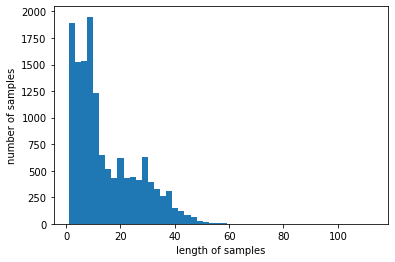

In [60]:
# 전체 데이터의 길이 분포
print('샘플의 최대 길이 : %d' % max(len(l) for l in sentences))
print('샘플의 평균 길이 : %f' % (sum(map(len, sentences))/len(sentences)))
plt.hist([len(s) for s in sentences], bins=50)
plt.xlabel('length of samples')
plt.ylabel('number of samples')
plt.show()

In [61]:
# 케라스 토크나이저를 통해서 토큰화와 정수 인코딩 진행
# 문장 데이터에 있는 모든 단어를 사용하지 않고 높은 빈도수를 가진 상위 약 4000개의 단어만을 사용

# 토큰화
max_words = 4000
src_tokenizer = Tokenizer(num_words=max_words, oov_token='OOV') #문장 데이터
src_tokenizer.fit_on_texts(sentences)

tar_tokenizer = Tokenizer() #레이블에 해당되는 개체명 태깅 정보
tar_tokenizer.fit_on_texts(ner_tags)

In [62]:
vocab_size = max_words
tag_size = len(tar_tokenizer.word_index) + 1
print('단어 집합의 크기 : {}'.format(vocab_size))
print('개체명 태깅 정보 집합의 크기 : {}'.format(tag_size))

단어 집합의 크기 : 4000
개체명 태깅 정보 집합의 크기 : 10


In [63]:
# 정수 인코딩
X_train = src_tokenizer.texts_to_sequences(sentences)
y_train = tar_tokenizer.texts_to_sequences(ner_tags)

In [64]:
print(X_train[0])
print(y_train[0])

[989, 1, 205, 629, 7, 3939, 216, 1, 3]
[4, 1, 7, 1, 1, 1, 7, 1, 1]


In [65]:
# 문장 데이터에 대해서는 일부 단어가 'OOV'로 대체된 상황
# 확인 위해 다시 디코딩(정수->텍스트 데이터) 작업을 함
# 이를 위해 인덱스로부터 단어를 리턴하는 index_to_word를 만듦

index_to_word = src_tokenizer.index_word
index_to_ner = tar_tokenizer.index_word

In [66]:
# 정수 인코딩 된 첫번째 문장 다시 디코딩
decoded = []
for index in X_train[0]: #첫번째 샘플 안의 인덱스들에 대해서
  decoded.append(index_to_word[index]) #다시 단어로 변환

print('기존 문장 : {}'.format(sentences[0]))
print('빈도수가 낮은 단어가 OOV 처리된 문장 : {}'.format(decoded))

기존 문장 : ['eu', 'rejects', 'german', 'call', 'to', 'boycott', 'british', 'lamb', '.']
빈도수가 낮은 단어가 OOV 처리된 문장 : ['eu', 'OOV', 'german', 'call', 'to', 'boycott', 'british', 'OOV', '.']


In [67]:
# 샘플들의 모든 길이를 임의 70으로 맞추기
# 케라스의 pad_sequences()

max_len = 70
X_train = pad_sequences(X_train, padding='post', maxlen=max_len)
y_train = pad_sequences(y_train, padding='post', maxlen=max_len)

In [68]:
# 데이터 분리
X_train, X_test, y_train, y_test = train_test_split(X_train, y_train, test_size = 0.2, random_state=777)

In [69]:
# 레이블에 해당하는 태깅 정보에 대해서 원-핫 인코딩 수행
y_train = to_categorical(y_train, num_classes=tag_size)
y_test = to_categorical(y_test, num_classes=tag_size)

In [70]:
# 각 데이터에 대한 크기
print('훈련 샘플 문장의 크기 : {}'.format(X_train.shape))
print('훈련 샘플 레이블의 크기 : {}'.format(y_train.shape))
print('테스트 샘플 문장의 크기 : {}'.format(X_test.shape))
print('테스트 샘플 레이블의 크기 : {}'.format(y_test.shape))

훈련 샘플 문장의 크기 : (11232, 70)
훈련 샘플 레이블의 크기 : (11232, 70, 10)
테스트 샘플 문장의 크기 : (2809, 70)
테스트 샘플 레이블의 크기 : (2809, 70, 10)


#### 4. 양방향 LSTM(Bi-directional LSTM)으로 개체명 인식기 만들기

In [74]:
from keras.models import Sequential
from keras.layers import Dense, Embedding, LSTM, Bidirectional, TimeDistributed
from tensorflow.keras.optimizers import Adam

In [77]:
# 모델
model = Sequential()
model.add(Embedding(input_dim=vocab_size, output_dim=128, input_length=max_len, mask_zero=True))
model.add(Bidirectional(LSTM(256, return_sequences=True)))
model.add(TimeDistributed(Dense(tag_size, activation='softmax')))

# 패딩을 하느라 숫자 0이 많아질 경우, Embedding()에 mask_zero=Trueㄹ르 설정하여
# 데이터에서 숫자 0은 패딩을 의미하므로 연산에서 제외시킨다는 옵션 줌

In [78]:
model.compile(loss='categorical_crossentropy', optimizer=Adam(0.001), metrics=['accuracy'])

In [79]:
model.fit(X_train, y_train, batch_size=128, epochs=8, validation_data=(X_test, y_test))

Epoch 1/8
88/88 [==============================] - 134s 1s/step - loss: 0.1833 - accuracy: 0.8266 - val_loss: 0.1214 - val_accuracy: 0.8334
Epoch 2/8
88/88 [==============================] - 124s 1s/step - loss: 0.0968 - accuracy: 0.8598 - val_loss: 0.0760 - val_accuracy: 0.8848
Epoch 3/8
88/88 [==============================] - 123s 1s/step - loss: 0.0658 - accuracy: 0.9054 - val_loss: 0.0541 - val_accuracy: 0.9231
Epoch 4/8
88/88 [==============================] - 121s 1s/step - loss: 0.0470 - accuracy: 0.9335 - val_loss: 0.0419 - val_accuracy: 0.9418
Epoch 5/8
88/88 [==============================] - 115s 1s/step - loss: 0.0360 - accuracy: 0.9492 - val_loss: 0.0363 - val_accuracy: 0.9496
Epoch 6/8
88/88 [==============================] - 112s 1s/step - loss: 0.0297 - accuracy: 0.9577 - val_loss: 0.0339 - val_accuracy: 0.9539
Epoch 7/8
88/88 [==============================] - 113s 1s/step - loss: 0.0253 - accuracy: 0.9637 - val_loss: 0.0332 - val_accuracy: 0.9543
Epoch 8/8
88/88 [===

In [80]:
print("\n 테스트 정확도: %.4f" % (model.evaluate(X_test, y_test)[1]))

88/88 [==============================] - 13s 148ms/step - loss: 0.0325 - accuracy: 0.9564

 테스트 정확도: 0.9564


In [83]:
# 실제로 맞추고 있는지를 테스트 데이터를 주고 직접 실제값과 비교
# 앞서 만들어 둔 인덱스로부터 단어와 개체명 태깅 정보를 리턴하는 index_to_word와 index_to_ner을 사용하여
# 테스트 데이터에 대한 예측값과 실제값을 비교 출력

i=10 # 확인하고 싶은 테스트용 샘플의 인덱스.
y_predicted = model.predict(np.array([X_test[i]])) # 입력한 테스트용 샘플에 대해서 예측 y를 리턴
y_predicted = np.argmax(y_predicted, axis=-1) # 원-핫 인코딩을 다시 정수 인코딩으로 변경함.
true = np.argmax(y_test[i], -1) # 원-핫 인코딩을 다시 정수 인코딩으로 변경함.

print("{:15}|{:5}|{}".format("단어", "실제값", "예측값"))
print(35 * "-")

for w, t, pred in zip(X_test[i], true, y_predicted[0]):
    if w != 0: # PAD값은 제외함.
        print("{:17}: {:7} {}".format(index_to_word[w], index_to_ner[t].upper(), index_to_ner[pred].upper()))

단어             |실제값  |예측값
-----------------------------------
sarah            : B-PER   B-PER
brady            : I-PER   I-PER
,                : O       O
whose            : O       O
republican       : B-MISC  B-MISC
husband          : O       O
was              : O       O
OOV              : O       B-PER
OOV              : O       O
in               : O       O
an               : O       O
OOV              : O       O
attempt          : O       O
on               : O       O
president        : O       O
ronald           : B-PER   B-PER
reagan           : I-PER   I-PER
,                : O       O
took             : O       O
centre           : O       O
stage            : O       O
at               : O       O
the              : O       O
democratic       : B-MISC  B-MISC
national         : I-MISC  I-MISC
convention       : I-MISC  I-MISC
on               : O       O
monday           : O       O
night            : O       O
to               : O       O
OOV              : O       O